In [1]:
## Import Packages
import numpy as np
import _pickle as pk
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import os 
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

plt.rcParams['axes.xmargin'] = 0 #default margin spacing for the edges
mpl.rc('font',size=40,**{'family':'sans-serif','sans-serif':['Arial']})
%matplotlib inline

In [2]:
Source = '/Volumes/eSSD0/Papers/GMD_CanESM_p1/Data/'
mods = ['CanESM2','CanESM5_p2']

lat = np.linspace(-87.864,87.864,64)
lon = np.linspace(0,357.1875,128)

landmask_source = '/Volumes/eSSD0/Papers/GMD_CanESM_p2/Analysis/Control/'
CanESM5 = pk.load(open(landmask_source+'results/CanESM5_CCF_picon.pi','rb'))
landmask = np.isnan(CanESM5['TADV'][0,:,:])
landvalid = np.isfinite(CanESM5['TADV'][0,:,:])
landmask_ext = np.tile(landmask[None,:,:],(150,1,1))

y = lat*np.pi/180
coslat = np.cos(y)
coslat = np.tile(coslat[None,:,None],(lon.size,1,150)).T
coslat_subtrop = coslat[:,10:54,:]
coslat_trop = coslat[:,21:43,:]

SST_time = {}
SST_picon = {}
SST_picon_gam = {}
for m in range(2):
    SST_time[mods[m]] = pk.load(open(Source+mods[m]+'/Time/'+mods[m]+'_SST_x4_TmSrs.pi','rb'))
    SST_picon[mods[m]] = np.nanmean(pk.load(open(Source+mods[m]+'/Time/'+mods[m]+'_SST_picon_TmSrs.pi','rb')),axis=0)

SST_time['piForcing'] = pk.load(open(Source+mods[m]+'/CFMIP/Tier_2/CanESM5_p2_SST_Tmsrs.pi','rb'))

<ipython-input-2-619b1e7402ff>:24: RuntimeWarning: Mean of empty slice
  SST_picon[mods[m]] = np.nanmean(pk.load(open(Source+mods[m]+'/Time/'+mods[m]+'_SST_picon_TmSrs.pi','rb')),axis=0)


In [3]:
SST_trop = {}
for models in SST_time.keys():

    if models == 'piForcing':
        SST_time[models][landmask_ext[:145,:,:]] = np.nan
    else:
        SST_time[models][landmask_ext] = np.nan
        
    SST_trop[models] = np.ma.masked_invalid(SST_time[models][:,21:43,:])

In [4]:
#get the 70th percentile
SST_filled = {}
SST_thresh = {}
SST_top30 = {}
for models in SST_time.keys():
    SST_filled[models] = np.ma.filled(SST_trop[models], np.nan)
    SST_thresh[models] = np.nanpercentile(SST_filled[models],70,axis=(1,2))

    if models == 'piForcing':
        nyrs = 145
    else:
        nyrs = 150

    SST_top30[models] = np.zeros([nyrs,22,128])

    for i in range(nyrs):
        SST_top30[models][i] = np.where(SST_filled[models][i,:,:]>SST_thresh[models][i],SST_filled[models][i,:,:],np.nan)


    SST_top30[models] = np.ma.masked_invalid(SST_top30[models])

In [5]:
SST_mn = {}
SST_T30_mn = {}
SST_sharp = {}
for models in SST_time.keys():

    if models == 'piForcing':
        coslat_trop = coslat[:145,21:43,:]
    else:
        coslat_trop = coslat[:,21:43,:]
        
    SST_mn[models] = np.ma.average(SST_trop[models],weights=coslat_trop,axis=(1,2))
    SST_T30_mn[models] = np.ma.average(SST_top30[models],weights=coslat_trop,axis=(1,2))
    SST_sharp[models] = SST_T30_mn[models]-SST_mn[models]

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
years = np.arange(150).reshape(-1,1)
ESM2_fit = LinearRegression().fit(years,SST_sharp['CanESM2'])
ESM2_pred = ESM2_fit.predict(years)
ESM2_alpha = ESM2_fit.coef_
ESM5_fit = LinearRegression().fit(years,SST_sharp['CanESM5_p2'])
ESM5_pred = ESM5_fit.predict(years)
ESM5_alpha = ESM5_fit.coef_

piForc_fit = LinearRegression().fit(years[:145],SST_sharp['piForcing'])
piForc_pred = piForc_fit.predict(years[:145])
piForc_alpha = piForc_fit.coef_

In [7]:
SST_picon_plot = {}
for mods in SST_picon.keys():

    SST_picon_plot[mods] = np.concatenate((SST_picon[mods][:,64:],SST_picon[mods][:,0:64]),axis=1)
    SST_picon_plot[mods],lon_cyc = add_cyclic_point(SST_picon_plot[mods],lon)

delta = SST_picon_plot['CanESM5_p2']-SST_picon_plot['CanESM2']

In [8]:
data_sw = {}
data_lw = {}

data_lw_SR = {}
data_sw_SR = {}

data_sw['amip'] = pk.load(open(Source+'CanESM5_p2/CFMIP/Tier_2/Fluxes/CanESM5_p2_TrCLsw_FLUX_FB_MZdecomp_Grid.pi','rb'))
data_lw['amip'] = pk.load(open(Source+'CanESM5_p2/CFMIP/Tier_2/Fluxes/CanESM5_p2_TrCLlw_FLUX_FB_MZdecomp_Grid.pi','rb'))   

data_sw['cpl'] = pk.load(open(Source+'CanESM5_p2/Fluxes/CanESM5_p2_TrCLsw_FLUX_FB_MZdecomp_Grid.pi','rb'))
data_lw['cpl'] = pk.load(open(Source+'CanESM5_p2/Fluxes/CanESM5_p2_TrCLlw_FLUX_FB_MZdecomp_Grid.pi','rb'))

data_sw_SR['amip'] = pk.load(open(Source+'CanESM5_p2/CFMIP/Tier_2/Fluxes/CanESM5_p2_TrCLsw_FLUX_FB_SRdecomp_Grid.pi','rb'))
data_lw_SR['amip'] = pk.load(open(Source+'CanESM5_p2/CFMIP/Tier_2/Fluxes/CanESM5_p2_TrCLlw_FLUX_FB_SRdecomp_Grid.pi','rb'))   

data_sw_SR['cpl'] = pk.load(open(Source+'CanESM5_p2/Fluxes/CanESM5_p2_TrCLsw_FLUX_FB_SRdecomp_Grid.pi','rb'))
data_lw_SR['cpl'] = pk.load(open(Source+'CanESM5_p2/Fluxes/CanESM5_p2_TrCLlw_FLUX_FB_SRdecomp_Grid.pi','rb'))  

In [9]:
#take the global, annual mean
data_lw_SRgam = dict()
data_sw_SRgam = dict()
for mods in data_sw_SR.keys():
    
    data_sw_SRgam[mods] = dict()
    data_lw_SRgam[mods] = dict()
    
    for prop in data_sw_SR[mods].keys():
        data_sw_SRgam[mods][prop] = np.average(data_sw_SR[mods][prop],weights=coslat[0])
        data_lw_SRgam[mods][prop] = np.average(data_lw_SR[mods][prop],weights=coslat[0])


#take the global, annual mean
data_lw_gam = dict()
data_sw_gam = dict()
for mods in data_sw.keys():
    data_sw_gam[mods] = dict()
    data_lw_gam[mods] = dict()
    
    for prop in data_sw[mods].keys():
        data_sw_gam[mods][prop] = dict()
        data_lw_gam[mods][prop] = dict()
        
        for ctp in data_sw[mods][prop].keys():
            data_sw_gam[mods][prop][ctp] = np.average(data_sw[mods][prop][ctp],weights=coslat[0])
            data_lw_gam[mods][prop][ctp] = np.average(data_lw[mods][prop][ctp],weights=coslat[0])

dict_keys(['Low', 'Low_unobscured', 'Hi'])

In [10]:
for mods in data_sw_SR.keys():
    data_sw_SRgam[mods]['Hi_obs'] = data_sw_SRgam[mods]['Low']-data_sw_SRgam[mods]['Low_unobscured']
    data_lw_SRgam[mods]['Hi_obs'] = data_lw_SRgam[mods]['Low']-data_lw_SRgam[mods]['Low_unobscured']

    data_sw_SRgam[mods]['Hi_cor'] = data_sw_SRgam[mods]['Hi']+data_sw_SRgam[mods]['Hi_obs']
    data_lw_SRgam[mods]['Hi_cor'] = data_lw_SRgam[mods]['Hi']+data_lw_SRgam[mods]['Hi_obs']

    
print(data_sw_SRgam['amip'].keys())

dict_keys(['Low', 'Low_unobscured', 'Hi', 'Hi_obs', 'Hi_cor'])


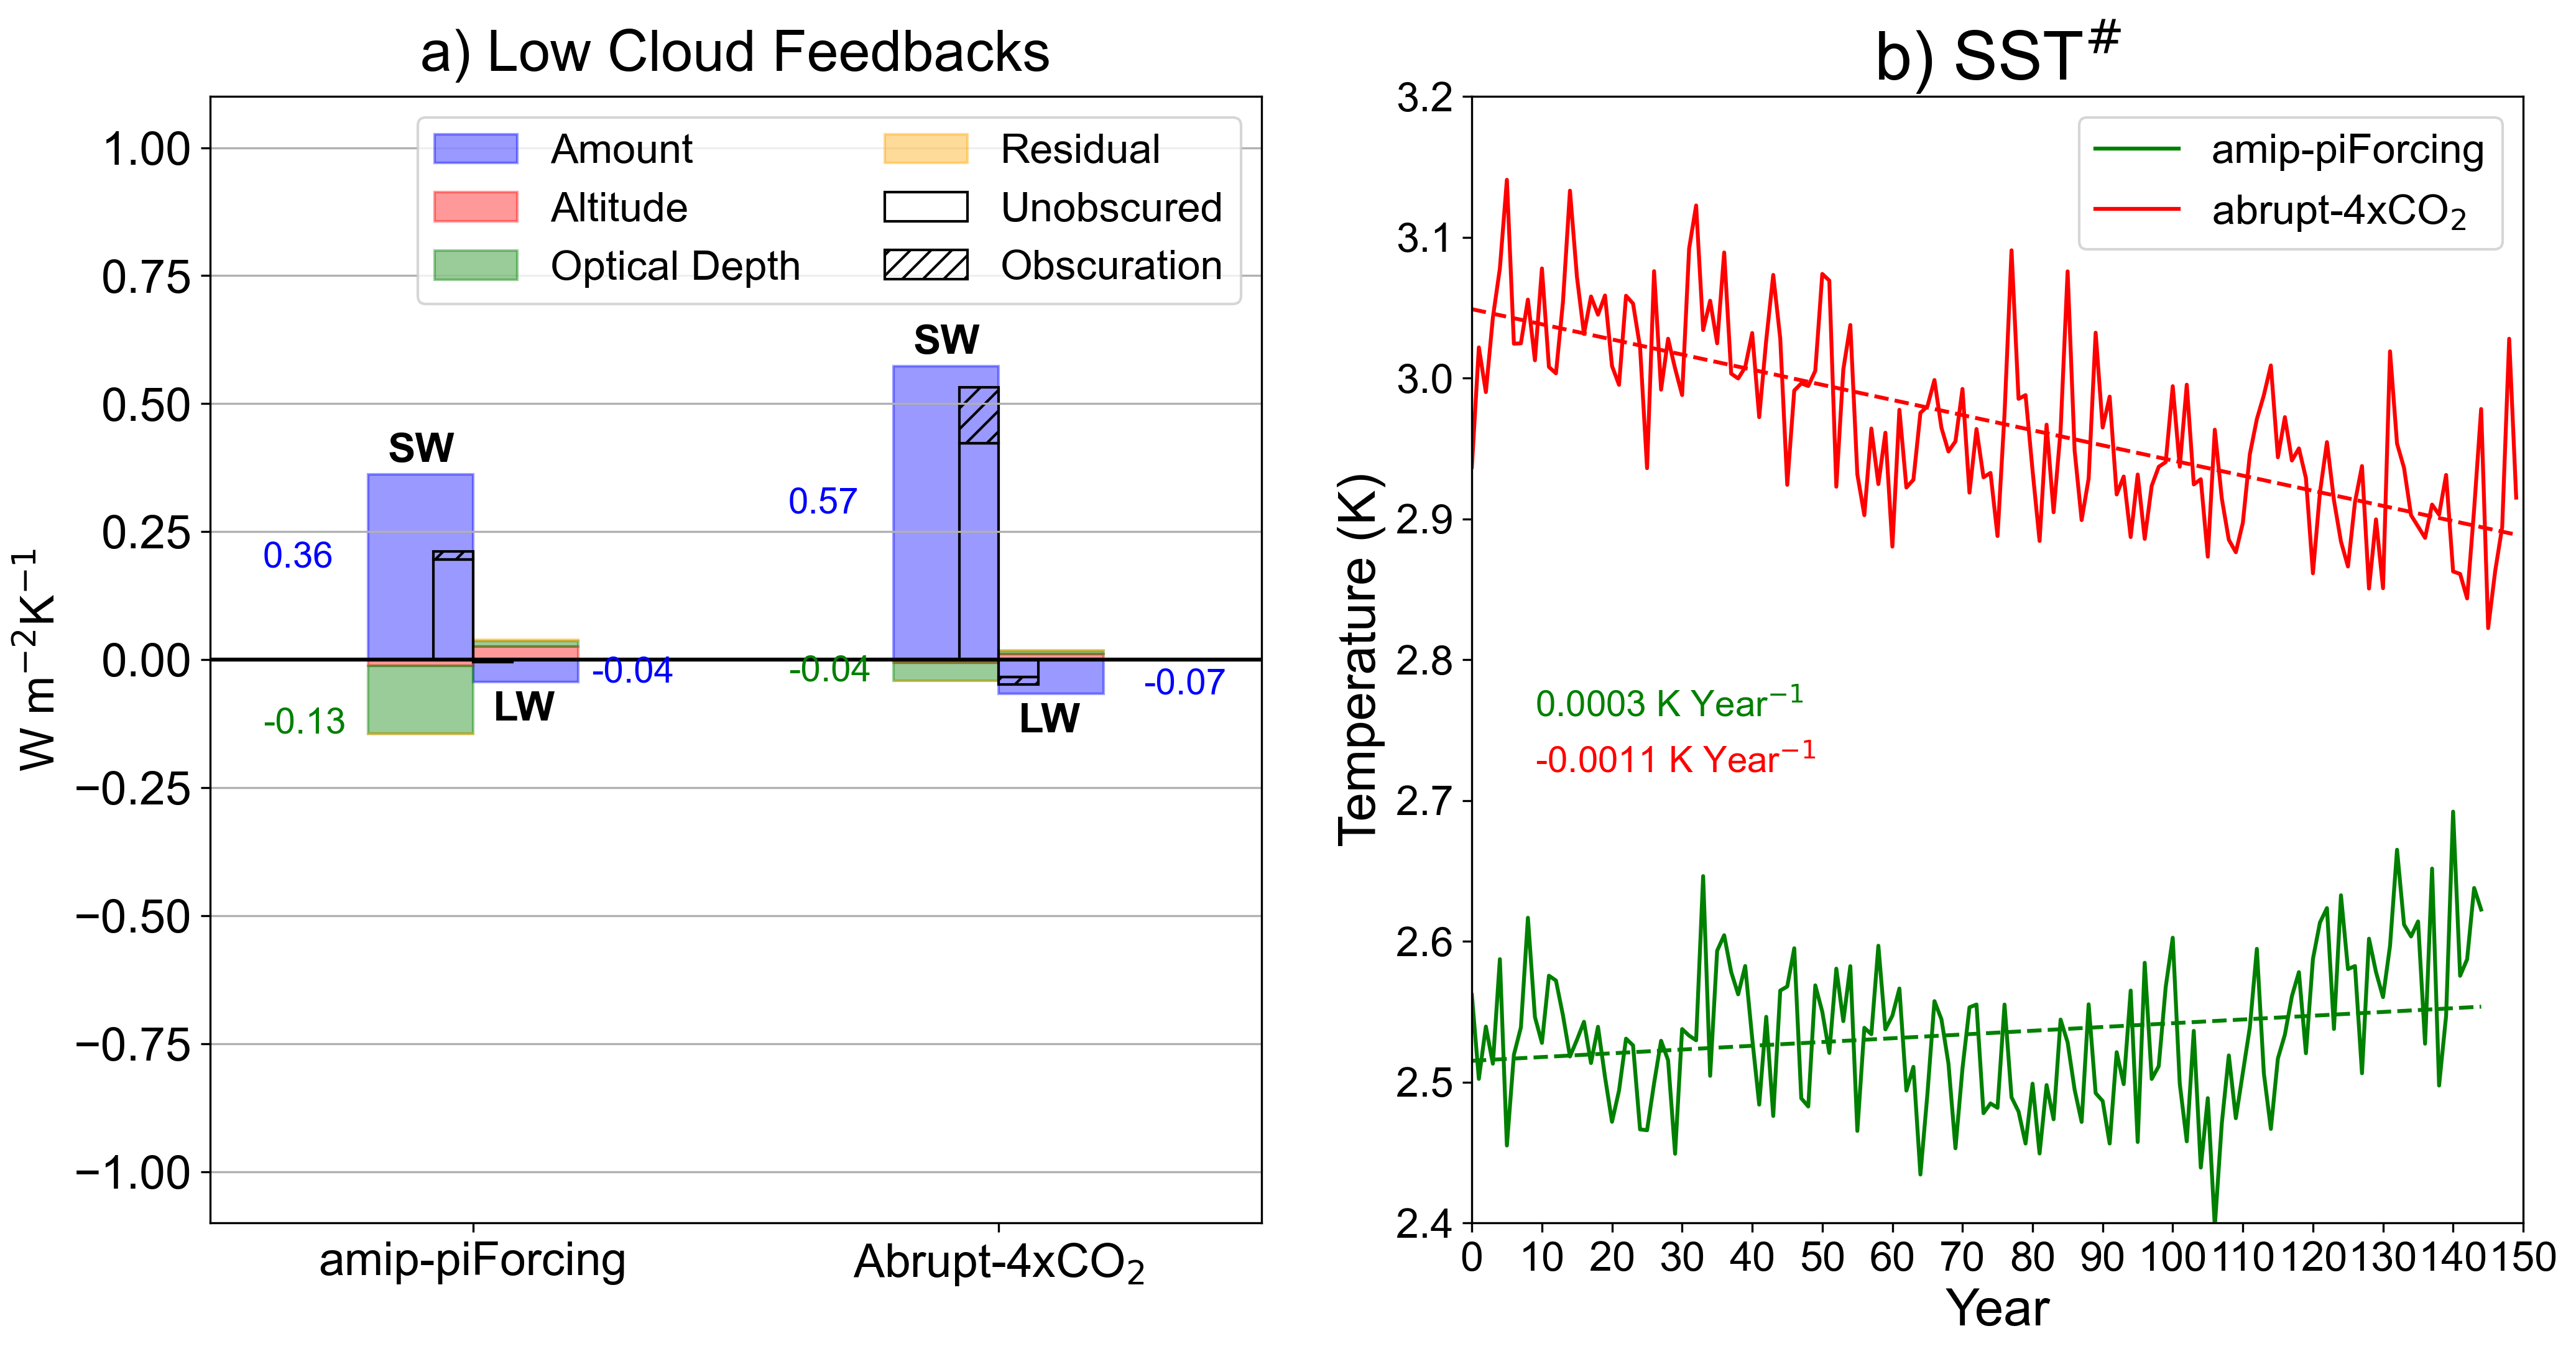

In [12]:
fig = plt.figure(figsize=(16,8),dpi=300)
gs = gridspec.GridSpec(1,2, width_ratios=[1,1],height_ratios=[1],figure=fig) 
plt.subplot(gs[0])
#plt.gca().spines['bottom'].set_position(('data',0))
#plt.gca().spines['top'].set_visible(False)
#plt.gca().spines['right'].set_visible(False)
plt.title('a) Low Cloud Feedbacks',fontsize=22,pad=10)

#amount
plt.bar(1,data_lw_gam['amip']['Amount']['Low'],align='edge',width=0.4,color='blue',\
        alpha=0.4,edgecolor='blue',label='Amount')
plt.text(1.45,data_lw_gam['amip']['Amount']['Low'],\
         str(round(data_lw_gam['amip']['Amount']['Low'],2)),color='blue',fontsize=14)
#plt.text(1.45,(data_lw_gam['amip']['Amount']['Low'])-0.05,\
#         '(-0.04)',color='k')
plt.bar(1,data_sw_gam['amip']['Amount']['Low'],align='edge',width=-0.4,color='blue',\
        alpha=0.4,edgecolor='blue')
plt.text(0.2,data_sw_gam['amip']['Amount']['Low']/2,\
         str(round(data_sw_gam['amip']['Amount']['Low'],2)),color='blue',fontsize=14)
#plt.text(0.3,(data_sw_gam['amip']['Amount']['Low']/2)-0.05,\
#         '(0.39)',color='k')

#altitude
plt.bar(1,data_lw_gam['amip']['Altitude']['Low'],align='edge',width=0.4,\
        color='red',alpha=0.4,edgecolor='red',label='Altitude')
#plt.text(1.45,data_lw_gam['amip']['Altitude']['Low'],\
#         str(round(data_lw_gam['amip']['Altitude']['Low'],2)),color='red')
plt.bar(1,data_sw_gam['amip']['Altitude']['Low'],align='edge',width=-0.4,\
        color='red',alpha=0.4,edgecolor='red')
#plt.text(0.2,-0.04,\
#         str(round(data_sw_gam['amip']['Altitude']['Low']/2,2)),color='red')

#optical depth
plt.bar(1,data_lw_gam['amip']['Optical Depth']['Low'],align='edge',width=0.4,\
        bottom=\
    data_lw_gam['amip']['Altitude']['Low'],\
        color='green',alpha=0.4,edgecolor='green',label='Optical Depth')
#plt.text(1.45,0.07,\
#         str(round(data_lw_gam['amip']['Optical Depth']['Low'],2)),color='green')
plt.bar(1,data_sw_gam['amip']['Optical Depth']['Low'],align='edge',width=-0.4,\
        bottom=\
    data_sw_gam['amip']['Altitude']['Low'],\
        color='green',alpha=0.4,edgecolor='green')
plt.text(0.2,data_sw_gam['amip']['Altitude']['Low']+\
         (data_sw_gam['amip']['Optical Depth']['Low']),\
         str(round(data_sw_gam['amip']['Optical Depth']['Low'],2)),color='green',fontsize=14)
#plt.text(0.30,(data_sw_gam['amip']['Altitude']['Low']+\
#         (data_sw_gam['amip']['Optical Depth']['Low']))-0.05,\
#         '(-0.12)',color='k')

#Residual
plt.bar(1,data_lw_gam['amip']['Residual']['Low'],align='edge',width=0.4,\
        bottom=data_lw_gam['amip']['Altitude']['Low']+\
        data_lw_gam['amip']['Optical Depth']['Low'],\
        color='orange',alpha=0.4,edgecolor='orange',label='Residual')
#plt.text(1.45,0.12,\
#         str(round(data_lw_gam['amip']['Residual']['Low'],2)),color='orange')
plt.bar(1,data_sw_gam['amip']['Residual']['Low'],align='edge',width=-0.4,\
        bottom=data_sw_gam['amip']['Altitude']['Low']+\
        data_sw_gam['amip']['Optical Depth']['Low'],\
        color='orange',alpha=0.4,edgecolor='orange')
#plt.text(0.2,-0.13,\
#         str(round(data_sw_gam['amip']['Residual']['Low'],2)),color='orange')

#cpl
#amount
plt.bar(3,data_lw_gam['cpl']['Amount']['Low'],align='edge',width=0.4,color='blue',\
        alpha=0.4,edgecolor='blue')
plt.text(3.55,data_lw_gam['cpl']['Amount']['Low'],\
         str(round(data_lw_gam['cpl']['Amount']['Low'],2)),color='blue',fontsize=14)
plt.bar(3,data_sw_gam['cpl']['Amount']['Low'],align='edge',width=-0.4,color='blue',\
        alpha=0.4,edgecolor='blue')
plt.text(2.2,data_sw_gam['cpl']['Amount']['Low']/2,\
         str(round(data_sw_gam['cpl']['Amount']['Low'],2)),color='blue',fontsize=14)

#altitude
plt.bar(3,data_lw_gam['cpl']['Altitude']['Low'],align='edge',width=0.4,\
        color='red',alpha=0.4,edgecolor='red',)
#plt.text(3.45,data_lw_gam['cpl']['Altitude']['Low'],\
#         str(round(data_lw_gam['cpl']['Altitude']['Low'],2)),color='red')
plt.bar(3,data_sw_gam['cpl']['Altitude']['Low'],align='edge',width=-0.4,\
        color='red',alpha=0.4,edgecolor='red')
#plt.text(2.35,-0.04,\
#         str(round(data_sw_gam['cpl']['Altitude']['Low']/2,2)),color='red')

#optical depth
plt.bar(3,data_lw_gam['cpl']['Optical Depth']['Low'],align='edge',width=0.4,\
        bottom=\
    data_lw_gam['cpl']['Altitude']['Low'],\
        color='green',alpha=0.4,edgecolor='green')
#plt.text(3.35,0.07,\
#         str(round(data_lw_gam['cpl']['Optical Depth']['Low'],2)),color='green')
plt.bar(3,data_sw_gam['cpl']['Optical Depth']['Low'],align='edge',width=-0.4,\
        bottom=\
    data_sw_gam['cpl']['Altitude']['Low'],\
        color='green',alpha=0.4,edgecolor='green')
plt.text(2.2,data_sw_gam['cpl']['Altitude']['Low']+\
         (data_sw_gam['cpl']['Optical Depth']['Low']),\
         str(round(data_sw_gam['cpl']['Optical Depth']['Low'],2)),color='green',fontsize=14)


#Residual
plt.bar(3,data_lw_gam['cpl']['Residual']['Low'],align='edge',width=0.4,\
        bottom=data_lw_gam['cpl']['Altitude']['Low']+\
        data_lw_gam['cpl']['Optical Depth']['Low'],\
        color='orange',alpha=0.4,edgecolor='orange')
#plt.text(3.45,0.12,\
#         str(round(data_lw_gam['cpl']['Residual']['Low'],2)),color='orange')
plt.bar(3,data_sw_gam['cpl']['Residual']['Low'],align='edge',width=-0.4,\
        bottom=data_sw_gam['cpl']['Altitude']['Low']+\
        data_sw_gam['cpl']['Optical Depth']['Low'],\
        color='orange',alpha=0.4,edgecolor='orange')


#Obscuration plots 
plt.bar(3,data_sw_SRgam['cpl']['Low_unobscured'],align='edge',width=-0.15,\
        color='None',edgecolor='k')
plt.bar(3,data_sw_SRgam['cpl']['Hi_obs'],align='edge',width=-0.15,hatch='///',\
        bottom=data_sw_SRgam['cpl']['Low_unobscured'],color='None',edgecolor='k')

plt.bar(1,data_sw_SRgam['amip']['Low_unobscured'],align='edge',width=-0.15,\
        color='None',edgecolor='k')
plt.bar(1,data_sw_SRgam['amip']['Hi_obs'],align='edge',width=-0.15,hatch='///',\
        bottom=data_sw_SRgam['amip']['Low_unobscured'],color='None',edgecolor='k')

plt.bar(3,data_lw_SRgam['cpl']['Low_unobscured'],align='edge',width=0.15,\
        color='None',edgecolor='k')
plt.bar(3,data_lw_SRgam['cpl']['Hi_obs'],align='edge',width=0.15,hatch='///',\
        bottom=data_lw_SRgam['cpl']['Low_unobscured'],color='None',edgecolor='k')

plt.bar(1,data_lw_SRgam['amip']['Low_unobscured'],align='edge',width=0.15,\
        color='None',edgecolor='k',label='Unobscured')
plt.bar(1,data_lw_SRgam['amip']['Hi_obs'],align='edge',width=0.15,hatch='///',\
        bottom=data_lw_SRgam['amip']['Low_unobscured'],color='None',edgecolor='k',\
        label='Obscuration')


plt.xlim(0,4)
plt.axhline(0,color='k')
plt.xticks([1,3],labels=['amip-piForcing','Abrupt-4xCO$_{2}$'],fontsize=18)
plt.ylabel('W m$^{-2}$K$^{-1}$',fontsize=18)
plt.ylim(-1.1,1.1)
plt.yticks(fontsize=18)
plt.grid(axis='y')
plt.legend(fontsize=16,ncol=2)
#plt.axhline(0,color='k')

plt.text(0.675,data_sw_gam['amip']['Amount']['Low']+0.025,'SW',color='k',fontweight='bold',fontsize=16)
plt.text(1.075,data_lw_gam['amip']['Amount']['Low']-0.075,'LW',color='k',fontweight='bold',fontsize=16)

plt.text(2.675,data_sw_gam['cpl']['Amount']['Low']+0.025,'SW',color='k',fontweight='bold',fontsize=16)
plt.text(3.075,data_lw_gam['cpl']['Amount']['Low']-0.075,'LW',color='k',fontweight='bold',fontsize=16);

plt.subplot(gs[1])
plt.title('b) SST$^{\#}$',fontsize=26)
plt.plot(SST_sharp['piForcing'],color='green',label='amip-piForcing')
plt.plot(piForc_pred,color='green',linestyle='--')
plt.plot(SST_sharp['CanESM5_p2'],color='red',label='abrupt-4xCO$_{2}$')
plt.plot(ESM5_pred,color='red',linestyle='--')

plt.text(9,2.76,'0.0003 K Year$^{-1}$',color='green',fontsize=14)
plt.text(9,2.72,'-0.0011 K Year$^{-1}$',color='red',fontsize=14)

plt.ylim(2.4,3.2)
plt.yticks(np.arange(2.4,3.21,.1),fontsize=16)
plt.xlabel('Year',fontsize=20)
plt.legend(fontsize=16)
plt.ylabel('Temperature (K)',fontsize=20)
plt.xticks(range(0,151,10),fontsize=16);

plt.savefig('Amip_Cld_Sharp.png',bbox_inches='tight')